In [1]:
import numpy as np
import tensorflow as tf
import tensorpack as tp

In [2]:
from functools import reduce
from tensorflow.python.ops import gradients_impl
from tensorflow.python.ops import array_ops, tensor_array_ops, control_flow_ops

def hessians_highrank(ys, xs, gradients=None, name="hessians", colocate_gradients_with_ops=False,
            gate_gradients=False, aggregation_method=None):
  """Constructs the Hessian (one or more rank matrix) of sum of `ys` with respect to `x` in `xs`.
  `hessians_highrank()` adds ops to the graph to output the Hessian matrix of `ys`
  with respect to `xs`.  It returns a list of `Tensor` of length `len(xs)`
  where each tensor is the Hessian of `sum(ys)`. This function currently
  only supports evaluating the Hessian with respect to (a list of) one-
  dimensional tensors.
  The Hessian is a matrix of second-order partial derivatives of a scalar
  tensor (see https://en.wikipedia.org/wiki/Hessian_matrix for more details).
  Args:
    ys: A `Tensor` or list of tensors to be differentiated.
    xs: A `Tensor` or list of tensors to be used for differentiation.
    name: Optional name to use for grouping all the gradient ops together.
      defaults to 'hessians'.
    colocate_gradients_with_ops: See `gradients()` documentation for details.
    gate_gradients: See `gradients()` documentation for details.
    aggregation_method: See `gradients()` documentation for details.
  Returns:
    A list of Hessian matrices of `sum(ys)` for each `x` in `xs`.
  Raises:
    LookupError: if one of the operations between `xs` and `ys` does not
      have a registered gradient function.
  """
  xs = gradients_impl._AsList(xs)
  kwargs = {
    'colocate_gradients_with_ops': colocate_gradients_with_ops,
    'gate_gradients': gate_gradients,
    'aggregation_method': aggregation_method
  }
  # Compute first-order derivatives and iterate for each x in xs.
  hessians = []
  _gradients = tf.gradients(ys, xs, **kwargs) if gradients is None else gradients
  for i, _gradient, x in zip(range(len(xs)), _gradients, xs):
    shape = x.shape
    _gradient = tf.reshape(_gradient, [-1])
    
    n = tf.size(x)
    loop_vars = [
      array_ops.constant(0, tf.int32),
      tensor_array_ops.TensorArray(x.dtype, n)
    ]
    _, hessian = control_flow_ops.while_loop(
      lambda j, _: j < n,
      lambda j, result: (j + 1, result.write(j, tf.gradients(_gradient[j], x, **kwargs)[0])),
      loop_vars
    )
    hessians.append(hessian.stack())
  return hessians

In [3]:
import time
import cv2
import numpy as np
import tensorflow as tf
import tensorpack as tp

from tensorpack import dataset
from tensorpack.dataflow import imgaug, AugmentImageComponent, BatchData, PrefetchData
import tensorpack.tfutils.symbolic_functions as symbf

import tensorflow.contrib.slim as slim
from tensorflow.python.framework import ops
from tensorflow.python.training import optimizer

class ModelMNIST10x10_simple(object):
    def __init__(self, learning_rate=1.0, batch_size=128, momentum=0.9):
        self.batch_size = batch_size
        self.inputs = [
            tf.placeholder(tf.float32, shape=(None, 10, 10, 1)),
            tf.placeholder(tf.int32, shape=(None,)),
            tf.placeholder(tf.float32, shape=(None, 10))
        ]
        
        self.probability, self.cost, self.accuracy = self._build_graph(self.inputs)
        self.op = self._get_optimize_operator(self.cost, learning_rate, momentum)
        self.dataflow = {
            'train':self._get_data('train'),
            'valid':self._get_data('test'),
        }
        
    def _build_graph(self, inputs):
        image, label, vector = inputs
        
        with slim.arg_scope([slim.layers.conv2d], weights_regularizer=slim.l2_regularizer(1e-4), activation_fn=tf.nn.relu), \
             slim.arg_scope([slim.layers.fully_connected], weights_regularizer=slim.l2_regularizer(1e-5)):
            l = slim.layers.conv2d(image, 8, [3, 3], padding='SAME', scope='conv0' ) # 10x10
            l = slim.layers.max_pool2d(l, [2, 2], scope='pool0') # 5x5
            l = slim.layers.conv2d(l, 8, [3, 3], scope='conv1') # 3x3
            l = slim.layers.conv2d(l, 8, [3, 3], scope='conv2') # 1x1
            l = slim.layers.flatten(l, scope='flatten')
            logits = slim.layers.fully_connected(l, 10, activation_fn=None, scope='fc0')

        # Currently there is no way to take the second derivative of sparse_softmax_cross_entropy_with_logits due to the fused implementation
        #cost = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=label)
        cost = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=vector)
        cost = tf.reduce_mean(cost, name='cross_entropy_loss')

        prob = tf.nn.softmax(logits, name='prob')
        accuracy = symbf.accuracy(logits, label, topk=1)
        return prob, cost, accuracy
    
    def _get_optimize_operator(self, cost, learning_rate=1.0, momentum=0.9):
        var_list = (tf.trainable_variables() + tf.get_collection(tf.GraphKeys.TRAINABLE_RESOURCE_VARIABLES))
        var_list += tf.get_collection(tf.GraphKeys._STREAMING_MODEL_PORTS)

        processors = [optimizer._get_processor(v) for v in var_list]
        var_refs = [p.target() for p in processors]

        # compute_gradients
        grads = tf.gradients(
                cost, var_refs,
                grad_ys=None, aggregation_method=None, colocate_gradients_with_ops=True)
        hessis = hessians_highrank(
                 cost, var_refs, gradients=grads,
                 aggregation_method=None, colocate_gradients_with_ops=True)
        
        second_order_grads = []
        for g, h in zip(grads, hessis):
            shape = g.shape
            d = int(reduce(lambda a,b: a*b, shape))

            g = tf.reshape(g, [d, 1])
            h = tf.reshape(h, [d, d]) + (tf.eye(d) * 1e-2)
            h_inv = tf.matrix_inverse(h)
            grad = tf.matmul(h_inv, g)
            grad = tf.reshape(grad, shape)
            second_order_grads.append(grad)
        grads_and_vars = list(zip(second_order_grads, var_list))
        
        self.grads = grads
        
        self.global_step = tf.contrib.framework.get_or_create_global_step()
        lr_schedule = {
            'step':     [                   1],
            'rate':     [0.1*learning_rate, learning_rate],
        }
        lr_schedule['step'] = ops.convert_n_to_tensor(lr_schedule['step'], tf.int64)
        learning_rate = tf.train.piecewise_constant(self.global_step, lr_schedule['step'], lr_schedule['rate'])
        #opt = tf.train.AdamOptimizer(learning_rate)
        opt = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
        #opt = tf.train.GradientDescentOptimizer(learning_rate)
        return opt.apply_gradients(grads_and_vars)
    
    def _get_data(self, train_or_test):
        BATCH_SIZE = self.batch_size
        isTrain = train_or_test == 'train'
        ds = dataset.Mnist(train_or_test)
        if isTrain:
            augmentors = [
                #imgaug.RandomApplyAug(imgaug.RandomResize((0.8, 1.2), (0.8, 1.2)), 0.3),
                #imgaug.RandomApplyAug(imgaug.RotationAndCropValid(15), 0.5),
                #imgaug.RandomApplyAug(imgaug.SaltPepperNoise(white_prob=0.01, black_prob=0.01), 0.25),
                imgaug.Resize((10, 10)),
                imgaug.CenterPaste((12, 12)),
                imgaug.RandomCrop((10, 10)),
                imgaug.MapImage(lambda x: x.reshape(10, 10, 1))
            ]
        else:
            augmentors = [
                imgaug.Resize((10, 10)),
                imgaug.MapImage(lambda x: x.reshape(10, 10, 1))
            ]
        ds = AugmentImageComponent(ds, augmentors)
        ds = BatchData(ds, BATCH_SIZE, remainder=not isTrain)
        if isTrain:
            ds = PrefetchData(ds, 3, 2)
        return ds

In [4]:
model = ModelMNIST10x10_simple(learning_rate=0.9, momentum=0.9, batch_size=128*100)

[1023 15:29:14 @fs.py:89] WRN Env var $TENSORPACK_DATASET not set, using /root/tensorpack_data for datasets.


In [5]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
print('session initialized')

session initialized


In [6]:
import sklearn.preprocessing

history = []
for epoch in range(30):
    result = {}
    
    model.dataflow['train'].reset_state()
    step, costs, accuracies = 0, [], []
    
    timestamp = time.time()
    for datapoint in model.dataflow['train'].get_data():
        datapoint.append( sklearn.preprocessing.label_binarize( datapoint[1], range(10) ).astype(np.float32) )
        _, cost, accuracy, grads = sess.run([model.op, model.cost, model.accuracy, model.grads],
                                     feed_dict=dict(zip(model.inputs, datapoint)))
        grads = [np.sum(np.abs(g)) for g in grads]
        costs.append(cost)
        accuracies.append(accuracy)
        step += 1
        #print('[train] epoch:%04d step:%04d cost:%.3f accuracy:%0.3f'%(epoch, step, cost, accuracy))
    eplapsed = time.time() - timestamp
    print('[%04d] [train] cost:%.3f accuracy:%0.3f elapsed:%.3fs'%(epoch+1, np.mean(costs), np.mean(accuracies), eplapsed), end=' ')
    result['train'] = {'epoch':epoch, 'cost':np.mean(costs), 'accuracy':np.mean(accuracies), 'grads_abs':grads}

    model.dataflow['valid'].reset_state()
    costs, accuracies = [], []
    timestamp = time.time()
    for datapoint in model.dataflow['valid'].get_data():
        datapoint.append( sklearn.preprocessing.label_binarize( datapoint[1], range(10) ).astype(np.float32) )
        cost, accuracy = sess.run([model.cost, model.accuracy],
                                     feed_dict=dict(zip(model.inputs, datapoint)))
        costs.append(cost)
        accuracies.append(accuracy)
    eplapsed = time.time() - timestamp
    print('[valid] cost:%.3f accuracy:%0.3f elapsed:%.3fs'%(np.mean(costs), np.mean(accuracies), eplapsed))
    result['valid'] = {'epoch':epoch, 'cost':np.mean(costs), 'accuracy':np.mean(accuracies)}
    
    history.append( result )

[0001] [train] cost:0.520 accuracy:0.115 elapsed:39.984s [valid] cost:0.328 accuracy:0.113 elapsed:0.359s
[0002] [train] cost:0.319 accuracy:0.181 elapsed:37.940s [valid] cost:0.284 accuracy:0.354 elapsed:0.329s
[0003] [train] cost:0.259 accuracy:0.414 elapsed:38.068s [valid] cost:0.220 accuracy:0.560 elapsed:0.309s
[0004] [train] cost:0.212 accuracy:0.577 elapsed:37.975s [valid] cost:0.183 accuracy:0.639 elapsed:0.287s
[0005] [train] cost:0.168 accuracy:0.685 elapsed:37.992s [valid] cost:0.149 accuracy:0.732 elapsed:0.295s
[0006] [train] cost:0.138 accuracy:0.757 elapsed:37.984s [valid] cost:0.122 accuracy:0.794 elapsed:0.292s
[0007] [train] cost:0.119 accuracy:0.803 elapsed:38.373s [valid] cost:0.110 accuracy:0.826 elapsed:0.290s
[0008] [train] cost:0.107 accuracy:0.830 elapsed:38.111s [valid] cost:0.097 accuracy:0.846 elapsed:0.287s
[0009] [train] cost:0.097 accuracy:0.849 elapsed:38.051s [valid] cost:0.088 accuracy:0.866 elapsed:0.289s
[0010] [train] cost:0.090 accuracy:0.862 elaps

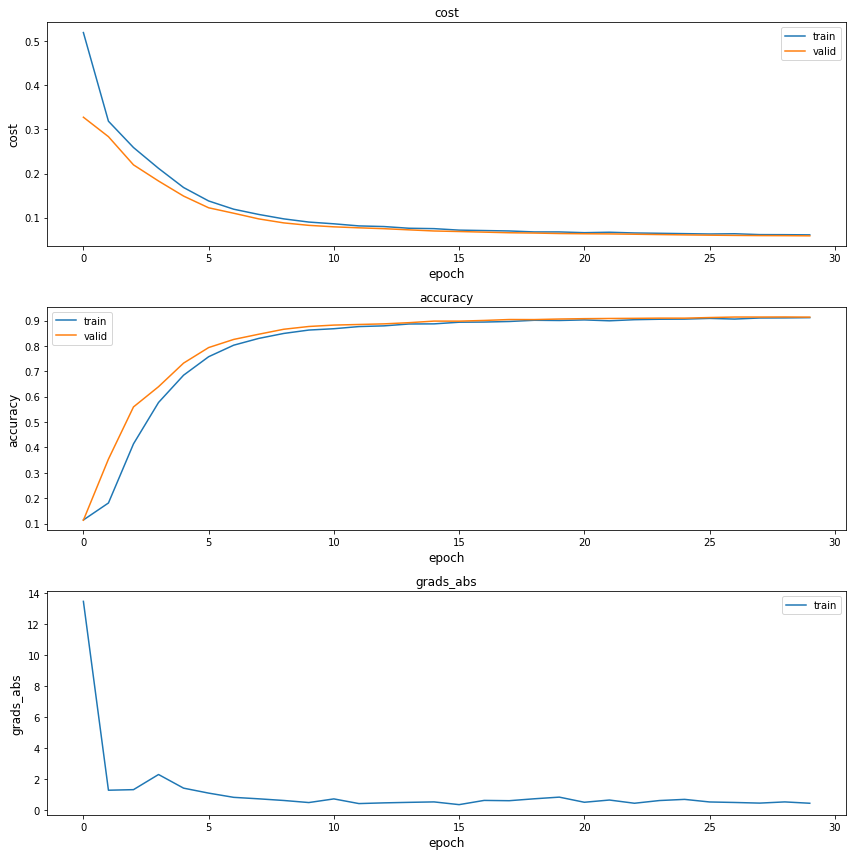

In [7]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(12, 4*3))
for i, label in enumerate(['cost', 'accuracy', 'grads_abs']):
    ax = fig.add_subplot(3, 1, i+1)
    ax.set_xlabel('epoch', fontsize=12)
    ax.set_ylabel(label, fontsize=12)
    ax.set_title(label, fontsize=12)
    for j, mode in enumerate(['train', 'valid']):
        if not label in history[0][mode]:
            continue
        ax.plot(np.array([h[mode]['epoch'] for h in history]), np.array([np.sum(h[mode][label]) for h in history]), label=mode)
    ax.legend()
plt.tight_layout()